# A simplified CenterNet architecture for ball detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple small object detection. We train our network to predict a heatmap of the balls location, and we refine these positions by using an offset map. In terms of architecture, the main difference with CenterNet is that we are not using any upsampling layers, since detection of tiny objects doesnt require a global information of the original image. Note that here, we dont regress any bounding box, what we want in the end is only the ball location as a point (pixel). This makes the training and inference of the network very fast.

# Summary
- import and display a ball dataset, e.g pool, soccer, tennis etc
- define utility functions to draw heatmap and how we can recover ball position from main and offset heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import torch.optim as optim

assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 1280
input_height = 720

# Model scale is 8, meaning that in the model prediction, we have heatmaps of dimensions 160 x 90
MODEL_SCALE = 8

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 2

# Load dataset

Image image_2066.png
Image shape = (720, 1280, 3)


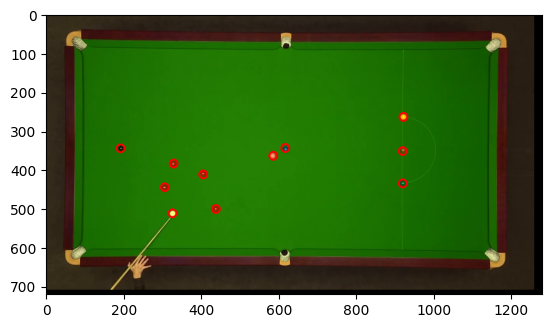

In [3]:
dataset_folder = "pool/images_hd_augmented/"
labels_file = "pool/labels_augmented_hd.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder, IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
labels = pd.read_csv(labels_file)
balls = labels[labels["image"] == IMAGE[:-4]][["x", "y"]].to_numpy()

print(f"Image shape = {img.shape}")

for ball in balls:
    cv2.circle(img, (int(ball[0]), int(ball[1])), radius=10, color=(255, 0, 0), thickness=3)

plt.imshow(img)

# Utility functions

Let's plot center points into the image.

In [4]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [5]:
# Heatmap function
# MODEL_SCALE = 8 ==> 1280 to 160, 720 ==> 90
def make_hm(target):
    hm = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        hm = draw_msra_gaussian(hm, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=0.5) # CHANGED SIGMA!!!
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        
    return hm, offset

In [6]:
def pred2point(hm, offset, thresh=0.99):
    """
    Based on the heatmap, find objects with thresholding
    then refine to exact location with the offset maps.
    We return points as pixel along with confidence scores
    """
    
    points = []
    
    # get centers
    pred = hm > thresh
    pred_centers = np.argwhere(pred)
    scores = hm[pred]
    
    for center, score in zip(pred_centers, scores):
        arr = np.array([center[1], center[0]]+offset[:, center[0], center[1]])*MODEL_SCALE
        points.append(arr)
    
    if len(scores) != 0:
        max_center = np.unravel_index(np.argmax(hm, axis=None), hm.shape)
        print("hm", hm[max_center[0], max_center[1]])
        print("Offset:",  offset[:, max_center[0], max_center[1]], "score: ", np.max(scores))
        
    return np.asarray(points), scores

In [7]:
def show_point(img, hm, offset, thresh=0.9):
    """Draw circles around detections"""
    
    points, scores = pred2point(hm, offset, thresh=thresh)
    
    if len(scores)==0:
        return img
    
    for point in points:
        cv2.circle(img,
                      center=(round(point[0]), round(point[1])),
                      radius=10,
                      color=(220, 220, 0), thickness=2)
            
    return img


# Make Pytorch dataset with dataloader

In [8]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder)), test_size=0.2, random_state=777)

In [9]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class SoccerBallDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, transform=None):
        self.img_id = img_id
        ball_dict = []
        for img_name in self.img_id:
            balls = labels[labels["image"] == f"{img_name[:-4]}"][["x", "y"]].to_numpy()
            for ball in balls:
                ball_dict.append({"image": img_name[:-4], "y": ball[1], "x": ball[0]})

        self.labels = pd.DataFrame.from_dict(ball_dict)
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(dataset_folder, self.img_id[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image']==self.img_id[idx][:-4]]
        hm, offset = make_hm(target)
        return img, hm, offset


In [10]:
traindataset = SoccerBallDataset(train_id)
valdataset = SoccerBallDataset(test_id)

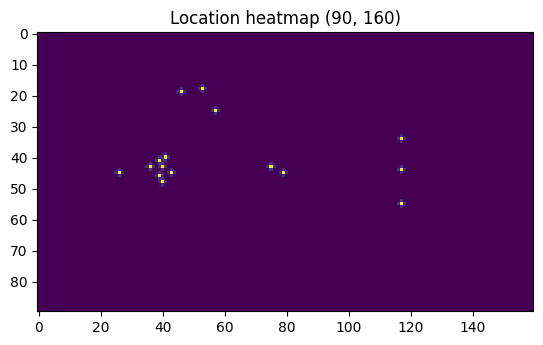

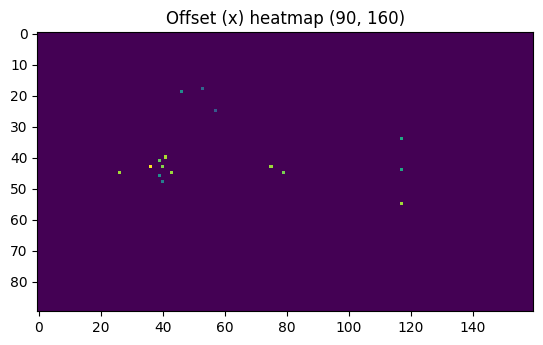

hm 1.0
Offset: [0.29454545 0.71967982] score:  1.0


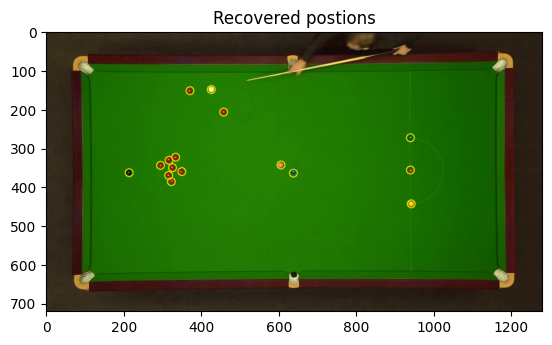

In [11]:
# Check traindataset

k = random.randint(0, len(train_id))
img, hm, offset = traindataset[k]

plt.imshow(hm)
plt.title(f"Location heatmap {hm.shape}")
plt.show()

plt.imshow(offset[0,:,:])
plt.title(f"Offset (x) heatmap {offset[0].shape}")
plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder, train_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = show_point(img, hm, offset, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [12]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True)

## Define Centernet model

In [13]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        
        # Select only first layers up when you reach 160x90 dimensions with 128 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-4])
        
        num_ch = 128
        head_conv = 64
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        x = self.base_model(x)
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        return outc, outo

/home/antoine/Documents/kaggle/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/antoine/Documents/kaggle/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 90, 160])
torch.Size([1, 2, 90, 160])


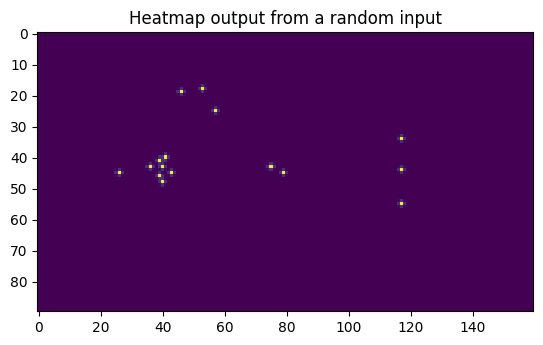

In [14]:
model = centernet()
# Check if it runs correctly
output = model(torch.rand(1,3,input_height,input_width))
print(output[0].size())
print(output[1].size())

plt.imshow(hm)
plt.title("Heatmap output from a random input")
plt.show()

In [15]:
summary(model, (1, 3, input_height, input_width))

Layer (type:depth-idx)                        Output Shape              Param #
centernet                                     [1, 1, 90, 160]           --
├─Sequential: 1-1                             [1, 128, 90, 160]         --
│    └─Conv2d: 2-1                            [1, 64, 360, 640]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 360, 640]         128
│    └─ReLU: 2-3                              [1, 64, 360, 640]         --
│    └─MaxPool2d: 2-4                         [1, 64, 180, 320]         --
│    └─Sequential: 2-5                        [1, 64, 180, 320]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 180, 320]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 180, 320]         73,984
│    └─Sequential: 2-6                        [1, 128, 90, 160]         --
│    │    └─BasicBlock: 3-3                   [1, 128, 90, 160]         230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 90, 160]         295,42

# Define Loss (Focal loss + L1-loss)

In [16]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _reg_loss(regr, gt_regr, hm_gt):
    ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
      
      For each positive pixel in the main heatmap (value = 1.0), we regress our 2 offsets x and y
      by using the L1-loss.
    '''
    mask = hm_gt.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask = mask.expand_as(gt_regr).float()
    
    assert regr.size() == mask.size()
    regr = regr * mask
    gt_regr = gt_regr * mask

    regr_loss = nn.functional.l1_loss(regr, gt_regr, reduction='sum')
    
    regr_loss = regr_loss / (num + 1e-4)
    return regr_loss

def global_loss(hm_pred, hm_gt, regr_pred, regr_gt):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred[:, 0])
  
    pred_mask = pred_mask.unsqueeze(1).float()
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss = _reg_loss(regr_pred, regr_gt, hm_gt)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss

# Training

In [17]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img, hm, offset) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt)
        loss = foc_loss + off_loss
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f})')
    
    scheduler.step()
    
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)

            # run model
            preds_hm, preds_offset = model(img)

            foc_loss, pos_loss, neg_loss, off_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt)
            
            loss = foc_loss + off_loss
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [18]:
model = centernet()
#model.load_state_dict(torch.load("pool.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

logs = []
best_loss = float('inf')

In [22]:
epochs = 10

for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "pool.pth")   


epochs 1/10
Learning rate : 0.0001


(l=17.19) (pos=0.812) (neg=16.190) (off=0.191): 100%|█| 1277/1277 [02:26<00:00, 
100%|█████████████████████████████████████████| 320/320 [00:33<00:00,  9.50it/s]


train loss : 17.1924
Pos loss : 0.8123
Neg loss : 16.1897
Off loss : 0.1905

Val loss : 0.8152
Val Pos loss : 0.2887
Val Neg loss : 0.3908
Val Off loss : 0.1357
Improved validation loss to 0.815
epochs 2/10
Learning rate : 0.0001


(l=0.68) (pos=0.241) (neg=0.307) (off=0.129): 100%|█| 1277/1277 [02:29<00:00,  8
100%|█████████████████████████████████████████| 320/320 [00:33<00:00,  9.57it/s]


train loss : 0.6772
Pos loss : 0.2415
Neg loss : 0.3066
Off loss : 0.1291

Val loss : 0.5501
Val Pos loss : 0.1869
Val Neg loss : 0.2502
Val Off loss : 0.1129
Improved validation loss to 0.550
epochs 3/10
Learning rate : 0.0001


(l=0.48) (pos=0.174) (neg=0.193) (off=0.115): 100%|█| 1277/1277 [02:30<00:00,  8
100%|█████████████████████████████████████████| 320/320 [00:32<00:00,  9.85it/s]


train loss : 0.4820
Pos loss : 0.1736
Neg loss : 0.1931
Off loss : 0.1153

Val loss : 0.4024
Val Pos loss : 0.1320
Val Neg loss : 0.1652
Val Off loss : 0.1051
Improved validation loss to 0.402
epochs 4/10
Learning rate : 0.0001


(l=0.37) (pos=0.132) (neg=0.135) (off=0.104): 100%|█| 1277/1277 [02:26<00:00,  8
100%|█████████████████████████████████████████| 320/320 [00:35<00:00,  9.01it/s]


train loss : 0.3712
Pos loss : 0.1317
Neg loss : 0.1354
Off loss : 0.1040

Val loss : 0.3626
Val Pos loss : 0.1091
Val Neg loss : 0.1430
Val Off loss : 0.1105
Improved validation loss to 0.363
epochs 5/10
Learning rate : 0.0001


(l=0.32) (pos=0.113) (neg=0.111) (off=0.099): 100%|█| 1277/1277 [02:42<00:00,  7
100%|█████████████████████████████████████████| 320/320 [00:37<00:00,  8.48it/s]


train loss : 0.3238
Pos loss : 0.1132
Neg loss : 0.1115
Off loss : 0.0991

Val loss : 0.3133
Val Pos loss : 0.1021
Val Neg loss : 0.1165
Val Off loss : 0.0947
Improved validation loss to 0.313
epochs 6/10
Learning rate : 1e-05


(l=0.24) (pos=0.085) (neg=0.080) (off=0.080): 100%|█| 1277/1277 [02:45<00:00,  7
100%|███████████████████████████████████████████| 320/320 [00:31<00:00, 10.04it/s]


train loss : 0.2449
Pos loss : 0.0848
Neg loss : 0.0803
Off loss : 0.0797

Val loss : 0.2714
Val Pos loss : 0.1022
Val Neg loss : 0.0896
Val Off loss : 0.0796
Improved validation loss to 0.271
epochs 7/10
Learning rate : 1e-05


(l=0.23) (pos=0.080) (neg=0.075) (off=0.076): 100%|█| 1277/1277 [02:42<00:00,  7.8
100%|███████████████████████████████████████████| 320/320 [00:32<00:00,  9.87it/s]


train loss : 0.2316
Pos loss : 0.0801
Neg loss : 0.0753
Off loss : 0.0762

Val loss : 0.2618
Val Pos loss : 0.1047
Val Neg loss : 0.0801
Val Off loss : 0.0771
Improved validation loss to 0.262
epochs 8/10
Learning rate : 1e-05


(l=0.22) (pos=0.078) (neg=0.069) (off=0.075): 100%|█| 1277/1277 [02:35<00:00,  8.2
100%|█████████████████████████████████████| 320/320 [00:34<00:00,  9.41it/s]


train loss : 0.2223
Pos loss : 0.0781
Neg loss : 0.0694
Off loss : 0.0747

Val loss : 0.2623
Val Pos loss : 0.0977
Val Neg loss : 0.0883
Val Off loss : 0.0762
epochs 9/10
Learning rate : 1e-05


(l=0.21) (pos=0.073) (neg=0.067) (off=0.073): 100%|█| 1277/1277 [02:30<00:00
100%|█████████████████████████████████████| 320/320 [00:34<00:00,  9.36it/s]


train loss : 0.2135
Pos loss : 0.0726
Neg loss : 0.0675
Off loss : 0.0734

Val loss : 0.2560
Val Pos loss : 0.0986
Val Neg loss : 0.0830
Val Off loss : 0.0744
Improved validation loss to 0.256
epochs 10/10
Learning rate : 1e-05


(l=0.21) (pos=0.069) (neg=0.064) (off=0.072): 100%|█| 1277/1277 [02:32<00:00
100%|█████████████████████████████████████| 320/320 [00:34<00:00,  9.30it/s]

train loss : 0.2054
Pos loss : 0.0694
Neg loss : 0.0639
Off loss : 0.0721

Val loss : 0.2493
Val Pos loss : 0.0951
Val Neg loss : 0.0777
Val Off loss : 0.0765
Improved validation loss to 0.249


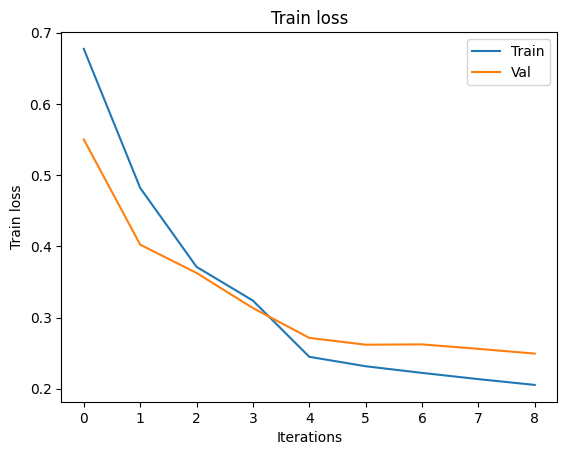

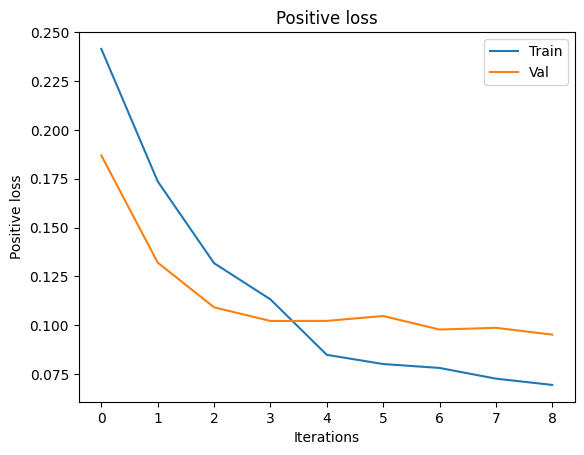

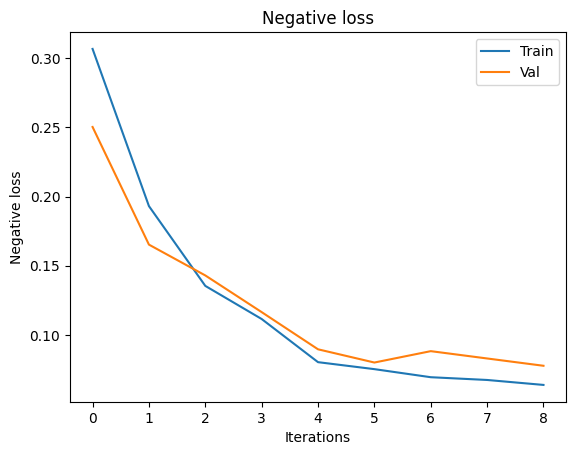

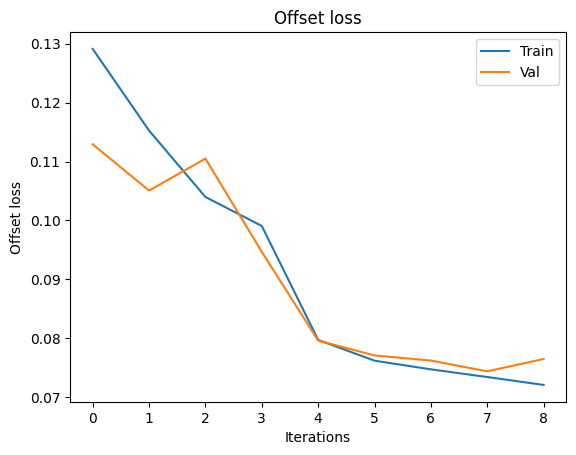

In [23]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

# Show predictions

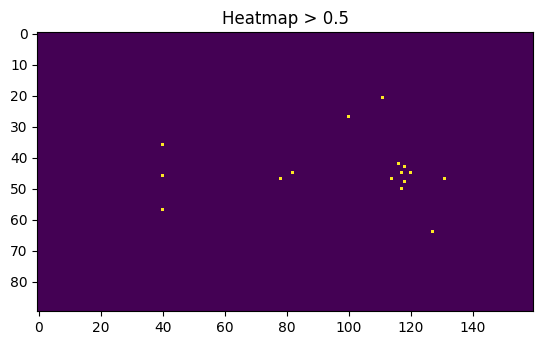

hm 0.9999881
Offset: [0.44567713 0.34730443] score:  0.9999881


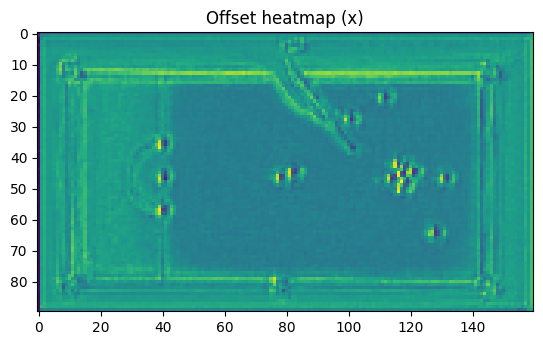

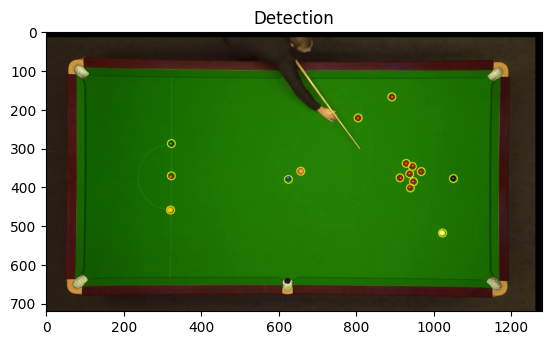

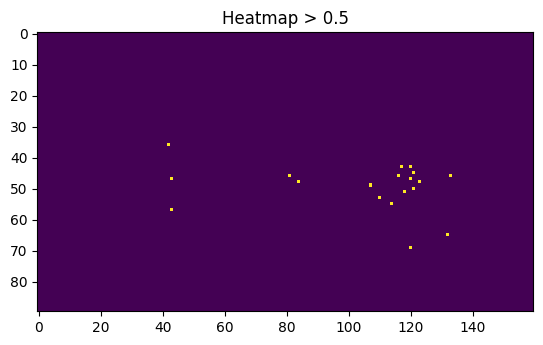

hm 0.99998605
Offset: [0.22439407 0.5279537 ] score:  0.99998605


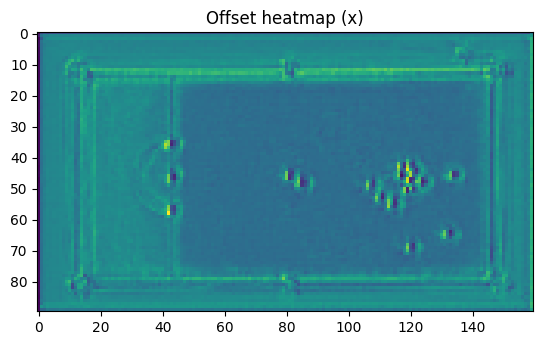

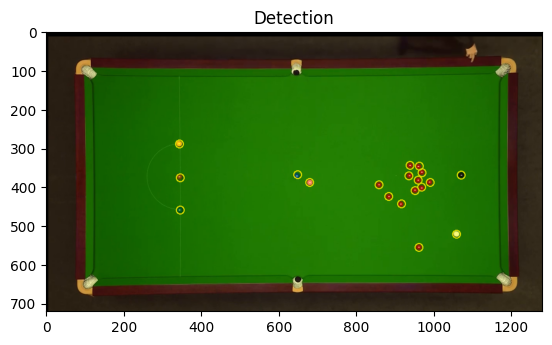

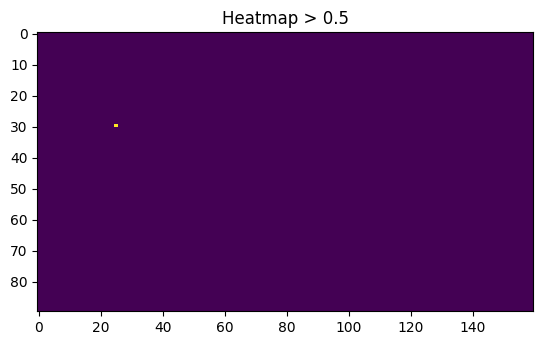

hm 0.94038105
Offset: [0.55447805 0.06428496] score:  0.94038105


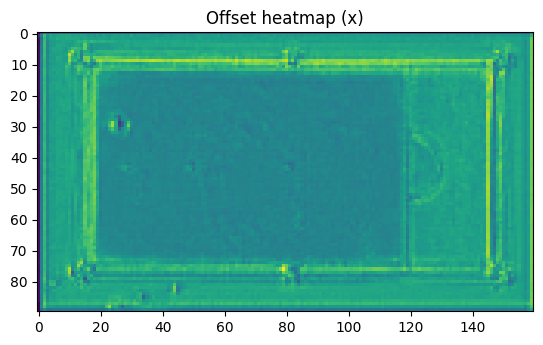

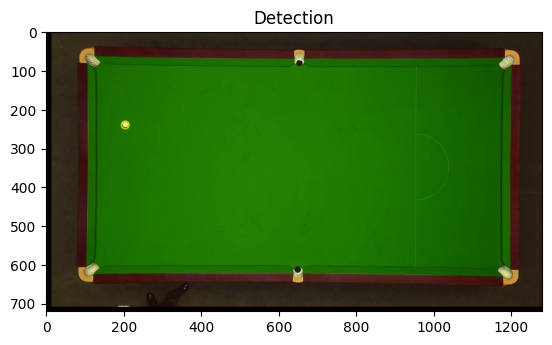

In [20]:
model.load_state_dict(torch.load("pool.pth"))
model.eval()

threshold = 0.5

for id in range(3):
    img, hm_gt, offset_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(dataset_folder, img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    
    plt.imshow(hm>threshold)
    plt.title(f"Heatmap > {threshold}")
    plt.show()
    
    sample = show_point(img, hm, offset, threshold)
    plt.imshow(offset[0])
    plt.title("Offset heatmap (x)")
    plt.show()
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()